# Определение возраста покупателей

**Условие:**   
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов. В нашем распоряжении набор фотографий людей с указанием возраста.     
**Цель:**     
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;     
- Контролировать добросовестность кассиров при продаже алкоголя.    

**Задача**:    

Построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [1]:
# импортируем все нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.rcParams["figure.figsize"] = (20,7)

In [2]:
# загружаем в датафрейм описание данных
df = pd.read_csv('/datasets/faces/labels.csv')
df['real_age'] = df['real_age'].apply(str)

In [3]:
# выводим данные на экран для проверки загрузки
display(df.head())
display(df.describe())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
count,7591,7591
unique,7591,97
top,005788.jpg,30
freq,1,317


In [4]:
# инициируем библиотеку ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# считываем данные с изображениями
train_generator = datagen.flow_from_dataframe(dataframe=df,
                                                 directory='/datasets/faces/final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='raw')

Found 7591 validated image filenames.


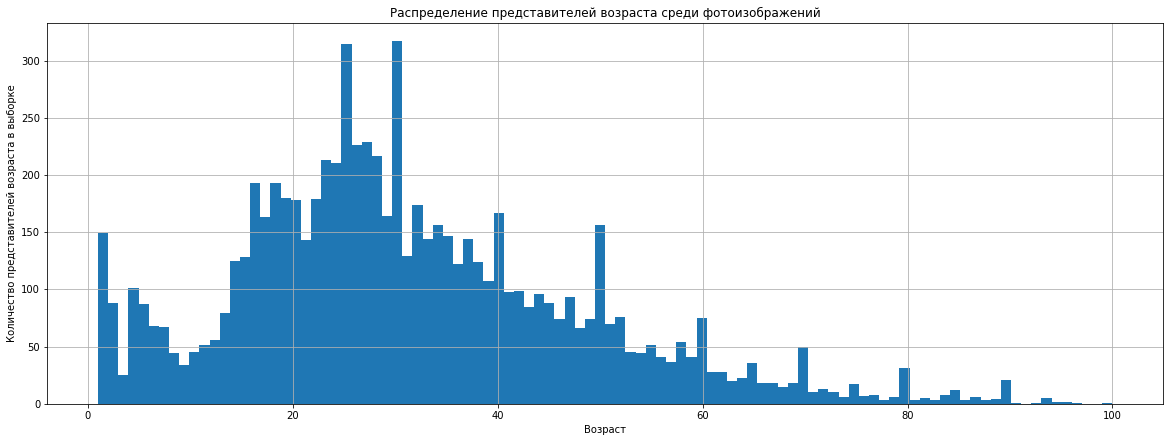

In [6]:
# построим график распределения возраста в колонке real_age
ax = df['real_age'].astype(int).hist(bins=100)
ax.set_title('Распределение представителей возраста среди фотоизображений')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество представителей возраста в выборке')
plt.show()

Всего у нас 97 классов и 7591 изображение.
Распределение похоже на нормальное, но имеет выбросы и смещение влево.
На фото есть и дети (1-2 года), и очень пожилые люди(100 лет).

(224, 224, 3)


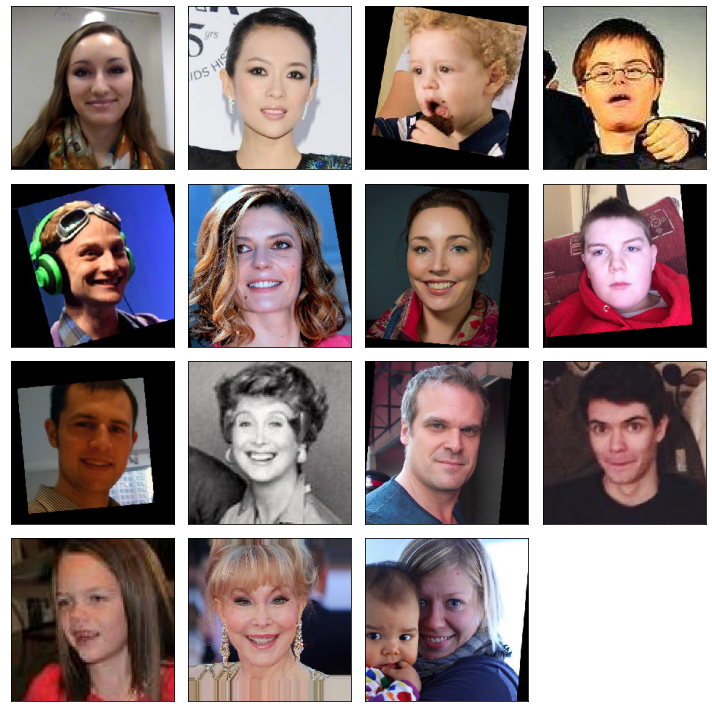

In [7]:
# выводим 15 изображений
features, target = next(train_generator)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
print(features[0].shape) 

**Выводы по результатам исследования данных:**

- мы имеем в распоряжении 7591 фотоизображение,
- 97 классов,
- размер изображений мы привели к 224х224 с 3 каналами (цветные),
- в представленных фотоизображениях можно выделить следующие особенности:
- присутствуют изображения, которые занимают всю площадь картинки,
- присутствуют изображения, которые содержат большое количество черного цвета,
- площадь лиц на фотографиях приблизительно одинаковая и отцентрированная, большинство сделаны в фас,
- фон может быть разным,
- встречаются известные люди,
- часть головы на некоторых изображениях обрезана,
- на некоторых фотографиях несколько лиц.

Указанные особенности (отцентрированность отображения и положение лица в фас), количество определенных классов для мультиклассификации позволят корректно выбрать методы работы с изображением для сверточной сети.

## Обучение модели

```python

import pandas as pd

from tensorflow.keras.layers import Dense, Flatten, Conv2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    train_datagen = ImageDataGenerator(
	validation_split=0.25,
	rescale=1./255,
	vertical_flip=True,
	horizontal_flip=True
	)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    	dataframe = pd.read_csv(path + 'labels.csv'),
    	directory = path + '/final_files',
    	x_col='file_name',
    	y_col='real_age',
    	target_size=(224, 224),
    	batch_size=32,
    	class_mode='raw',
    	subset='training',
    	seed=12345)
    train_data = train_datagen_flow
    return train_data

def load_test(path):
    test_datagen = ImageDataGenerator(
	rescale=1./255,
	validation_split=0.25
	)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    	dataframe = pd.read_csv(path + 'labels.csv'),
    	directory = path + '/final_files',
    	x_col='file_name',
    	y_col='real_age',
    	target_size=(224, 224),
    	batch_size=32,
    	class_mode='raw',
    	subset='validation',
    	seed=12345)
    test_data = test_datagen_flow
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/7
2024-12-27 19:03:39.514205: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-27 19:03:39.845721: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 56s - loss: 249.4614 - mae: 11.5893 - val_loss: 755.7181 - val_mae: 22.5672
Epoch 2/7
178/178 - 45s - loss: 103.9777 - mae: 7.6698 - val_loss: 679.4473 - val_mae: 21.0735
Epoch 3/7
178/178 - 45s - loss: 80.5702 - mae: 6.7734 - val_loss: 209.7608 - val_mae: 11.0360
Epoch 4/7
178/178 - 45s - loss: 65.8364 - mae: 6.1351 - val_loss: 159.9446 - val_mae: 10.0718
Epoch 5/7
178/178 - 45s - loss: 52.9872 - mae: 5.5249 - val_loss: 90.1447 - val_mae: 7.0834
Epoch 6/7
178/178 - 45s - loss: 43.1874 - mae: 5.0161 - val_loss: 81.7633 - val_mae: 6.7036
Epoch 7/7
178/178 - 45s - loss: 38.8630 - mae: 4.7779 - val_loss: 73.4428 - val_mae: 6.3999
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 73.4428 - mae: 6.3999

```

**Вывод:** удалось построить модель, которая определяет возраст человека по фотографии с погрешностью **не более 7 лет**, что соответствует условию проекта.

## Анализ обученной модели

Построенная нами модель позволяет определять возраст людей по фотографии с ошибкой не более 7 лет, что не является критичным, если человек в среднем или пожилом возрасте, предпочтения у таких людей с разницей в 7 лет не сильно отличаются друг от друга, но может быть критичным для детей, подростков и молодежи, потому что интересы этих групп людей сильно разнятся.     
Для повышения качества определения возраста, можно попробовать обучение на более качественных фотографиях, у которых мало шумов в виде предметов одежды, которые закрывают часть лица, количество людей на фото должно быть равно 1.